<a href="https://colab.research.google.com/github/YTIputi/Linear-Classification/blob/main/LinearClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Requirements**

In [ ]:
pip install ydata_profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=87da5e6b29ea99c871b2c57f738414b23e605c50c0678130cda748caa24693c5
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


---

# **Linear classification**

In this notebook I will look at linear classifiers. I understand that they will most likely have **low accuracy**. However, I do this for the sake of an example of **using** and **tuning** linear models.

### **Libraries**

In [ ]:
import kagglehub
import os
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

---

## **Dataset**

**Drug Classification**

Since as a beginner in machine learning it would be a great opportunity to try some techniques to predict the outcome of the drugs that might be accurate for the patient

**Features**

*The target feature is*

* Drug type

*The feature sets are:*

* Age
* Sex
* Blood Pressure Levels (BP)
* Cholesterol Levels
* Na to Potassium Ration

In [ ]:
path = kagglehub.dataset_download("prathamtripathi/drug-classification")
os.listdir(path)

100%|██████████| 1.68k/1.68k [00:00<00:00, 840kB/s]

Extracting files...


['drug200.csv']

In [ ]:
data = pd.read_csv(os.path.join(path, os.listdir(path)[0]))
new_data = data.copy()
new_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
number_features, category_features = new_data.select_dtypes(include=['number']).columns, new_data.select_dtypes(exclude=['number']).columns
number_features.shape, category_features.shape

((2,), (4,))

---

## **Profiling**

I use ydata_profiling to get a report on the data

In [ ]:
profile = ProfileReport(new_data, title="Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00, 50.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There are no missing values ​​or duplicates in the data, I will proceed with preprocessing. (I don't see any strong outliers in the data.)

---

## **Preprocessing**

It is necessary to transform categorical features so that the model can process them later. It is also necessary to standardize real features so that the model converges to the optimal parameters faster.

I use OneHotEncoder for categorization (removing the last column so that there is no unnecessary information in the data and the model does not overfit).

StandardScaler for standardization.

I use transformer to apply different transformations to the data (it takes into account data leakage). Thanks to it, the code becomes cleaner

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), number_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), category_features.drop('Drug'))
    ])


I use LabelEncoder to categorize the target feature

In [ ]:
label_encoder = LabelEncoder()
encoder_drug = label_encoder.fit_transform(new_data['Drug'])
encoder_drug.shape

(200,)

I combine categorical and numerical data

In [ ]:
X, y = new_data.drop(['Drug'], axis=1), encoder_drug
X.shape, y.shape

((200, 5), (200,))

I split the data into training and testing data, taking into account their distribution.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, train_size=.8, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 5), (40, 5), (160,), (40,))

---

## **Model**

Let's consider three linear models: logistic regression SVM, SGD with perceptron error

I used StratifiedKFold when training models. The data is small, to get accurate results from the model, it is better to use KFold. However, the target values ​​are not balanced (different amounts), so I use StratifiedKFold to take into account the internal structure of the data

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

### **LogisticRegression**

In [ ]:
logreg_models = []
logreg_scores = []

for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    clf = make_pipeline(preprocessor, LogisticRegression())
    clf.fit(X_tr, y_tr)

    score = clf.score(X_val, y_val)
    print(f"Accuracy on the fold: {score:.4f}")

    logreg_models.append(clf)
    logreg_scores.append(score)

print(f"Mean accuracy: {np.mean(logreg_scores):.4f}")

Accuracy on the fold: 1.0000
Accuracy on the fold: 0.9688
Accuracy on the fold: 0.9375
Accuracy on the fold: 0.9688
Accuracy on the fold: 0.9062
Mean accuracy: 0.9563


---

### **LinearSVC**

In [ ]:
svm_models = []
svm_scores = []

for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    clf = make_pipeline(preprocessor, LinearSVC())
    clf.fit(X_tr, y_tr)

    score = clf.score(X_val, y_val)
    print(f"Accuracy on the fold: {score:.4f}")

    svm_models.append(clf)
    svm_scores.append(score)

print(f"Mean accuracy: {np.mean(svm_scores):.4f}")

Accuracy on the fold: 1.0000
Accuracy on the fold: 0.9375
Accuracy on the fold: 0.9375
Accuracy on the fold: 0.9688
Accuracy on the fold: 0.9688
Mean accuracy: 0.9625


---

### **SGDClassifier**

In [ ]:
perceptron_models = []
perceptron_scores = []

for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    clf = make_pipeline(preprocessor, SGDClassifier(loss='perceptron'))
    clf.fit(X_tr, y_tr)

    score = clf.score(X_val, y_val)
    print(f"Accuracy on the fold: {score:.4f}")

    perceptron_models.append(clf)
    perceptron_scores.append(score)

print(f"Mean accuracy: {np.mean(perceptron_scores):.4f}")

Accuracy on the fold: 1.0000
Accuracy on the fold: 0.9375
Accuracy on the fold: 0.8750
Accuracy on the fold: 1.0000
Accuracy on the fold: 0.8750
Mean accuracy: 0.9375


### **Summary**

After StratifiedKFold, we got 5 models. We need to choose an approach to obtain predictions. In the first case, I consider the predictions of all models and take the mode for them. In the second case, I choose the model with the best accuracy and make predictions.

#### **LogisticRegression**

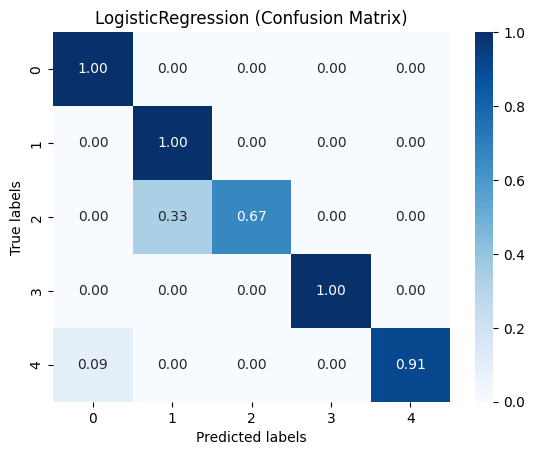

0.95


In [ ]:
all_preds = np.array([model.predict(X_test) for model in logreg_models])
frequency_prediction, _ = mode(all_preds, axis=0)

cm_frequency_prediction = confusion_matrix(y_test, frequency_prediction, normalize='true')

sns.heatmap(cm_frequency_prediction, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LogisticRegression (Confusion Matrix)')
plt.show()

print(accuracy_score(frequency_prediction, y_test))

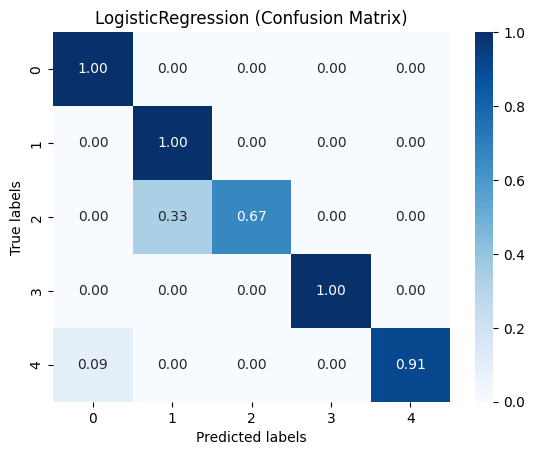

0.95


In [ ]:
best_prediction = logreg_models[np.argmax(logreg_scores)].predict(X_test)

cm_best_prediction = confusion_matrix(y_test, best_prediction, normalize='true')

sns.heatmap(cm_best_prediction, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LogisticRegression (Confusion Matrix)')
plt.show()

print(accuracy_score(best_prediction, y_test))

---

#### **LinearSVC**

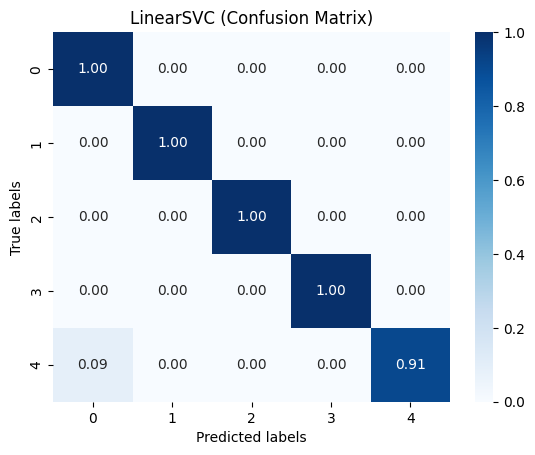

0.975


In [ ]:
all_preds = np.array([model.predict(X_test) for model in svm_models])
frequency_prediction, _ = mode(all_preds, axis=0)

cm_frequency_prediction = confusion_matrix(y_test, frequency_prediction, normalize='true')

sns.heatmap(cm_frequency_prediction, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LinearSVC (Confusion Matrix)')
plt.show()

print(accuracy_score(frequency_prediction, y_test))

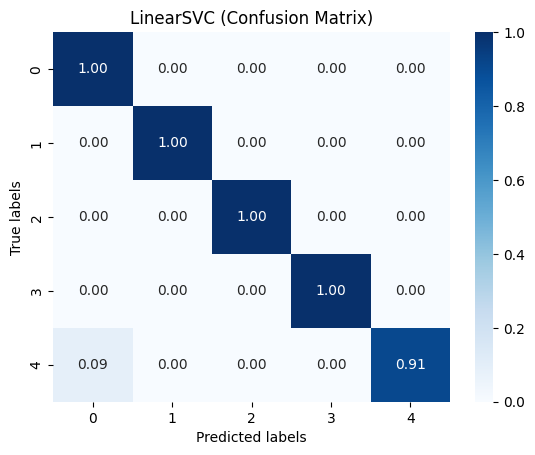

0.975


In [ ]:
best_prediction = svm_models[np.argmax(svm_scores)].predict(X_test)

cm_best_prediction = confusion_matrix(y_test, best_prediction, normalize='true')

sns.heatmap(cm_best_prediction, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LinearSVC (Confusion Matrix)')
plt.show()

print(accuracy_score(best_prediction, y_test))

---

#### **SGDClassifier**

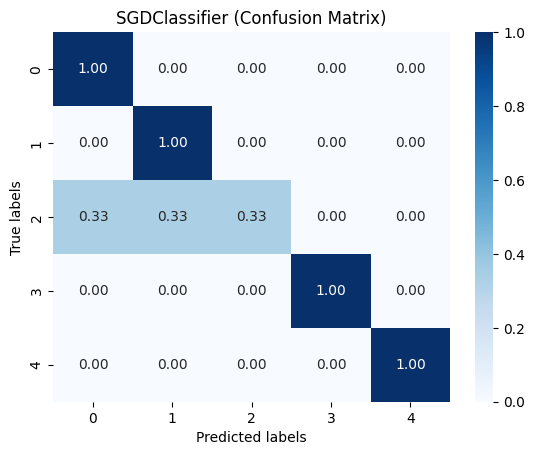

0.95


In [ ]:
all_preds = np.array([model.predict(X_test) for model in perceptron_models])
frequency_prediction, _ = mode(all_preds, axis=0)

cm_frequency_prediction = confusion_matrix(y_test, frequency_prediction, normalize='true')

sns.heatmap(cm_frequency_prediction, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SGDClassifier (Confusion Matrix)')
plt.show()

print(accuracy_score(frequency_prediction, y_test))

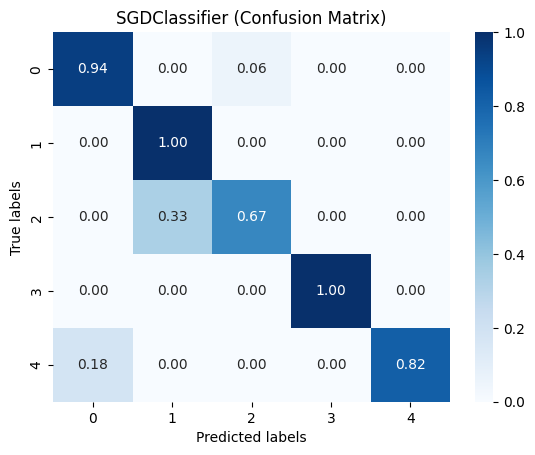

0.9


In [ ]:
best_prediction = perceptron_models[np.argmax(perceptron_scores)].predict(X_test)

cm_best_prediction = confusion_matrix(y_test, best_prediction, normalize='true')

sns.heatmap(cm_best_prediction, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SGDClassifier (Confusion Matrix)')
plt.show()

print(accuracy_score(best_prediction, y_test))